# Setting Up

We'll first load the packages we're going to be using. 

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,8]

import umap

from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# The Data

For this exercise we'll use the well-known MNIST digits database. Since this dataset is such a standard, it's conveniently available within scikit-learn. The data consists of the pixel values of a set of 8x8 images of handwritten digits, as well as the corresponding labels. 

This is typically used for classification, but the data has a structure that is well suited to a clustering example (and knowing the labels makes it easier to check our results). 

(1797, 64)


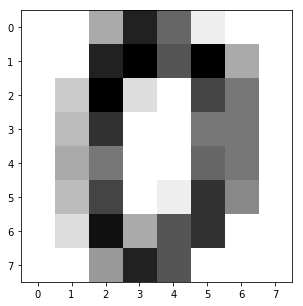

In [6]:
digits = load_digits()
X = digits.data
labels = digits.target
print(X.shape)

ex_image = X[0].reshape([8,8])
plt.figure(figsize=(5,5))
plt.imshow(ex_image, plt.cm.gray_r)

# Visualizing the Data

The dimension of our data is 64, making it a challenge to visualize. In order to do this, we'll use UMAP to reduce the data to two dimensions. This will allow us to look for structure. 

It's important to first scale the features to be in the same range, because both the embedding and clustering algorithms use distances between points.

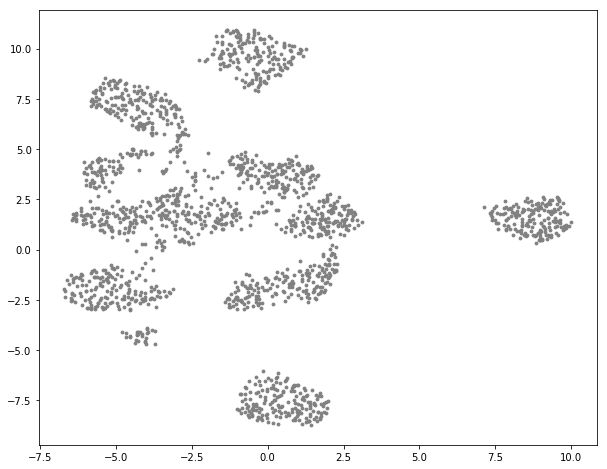

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

embed = umap.UMAP(n_neighbors=50, min_dist=0.5, metric='euclidean', random_state=111)
X_reduced = embed.fit_transform(X)

plt.scatter(X_reduced[:,0], X_reduced[:,1], s=8, c='grey')

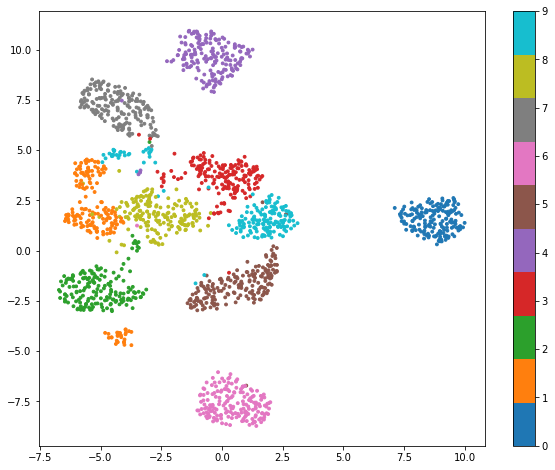

In [8]:
plt.scatter(X_reduced[:,0], X_reduced[:,1], s=8, c=labels, cmap='tab10')
plt.colorbar()

We can see that the structure in our dataset doesn't correspond *exactly* to the digit groups as we would expect. There seem to be some subgroups; let's look at the ones to show this.

We'll first use a simple histogram to show the distribution of values of the y-coordinate of our embedding, for the ones.
Then we can look at some example images falling into these subgroups.

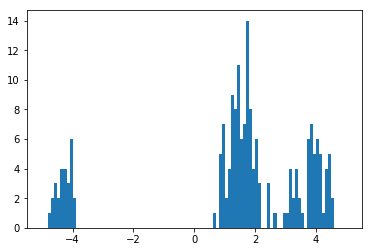

In [9]:
plt.figure(figsize=(6, 4))
_ = plt.hist(X_reduced[labels==1, 1], bins=np.arange(-5, 5.1, 0.1))

In [10]:
ex1a = X[(X_reduced[:,1] < -3) & (labels == 1)]
ex1b = X[(X_reduced[:,1] > 0) & (X_reduced[:,1] < 2) & (labels == 1)]
ex1c = X[(X_reduced[:,1] > 2.5) & (X_reduced[:,1] < 3.5) & (labels == 1)]
ex1d = X[(X_reduced[:,1] > 4) & (labels == 1)]

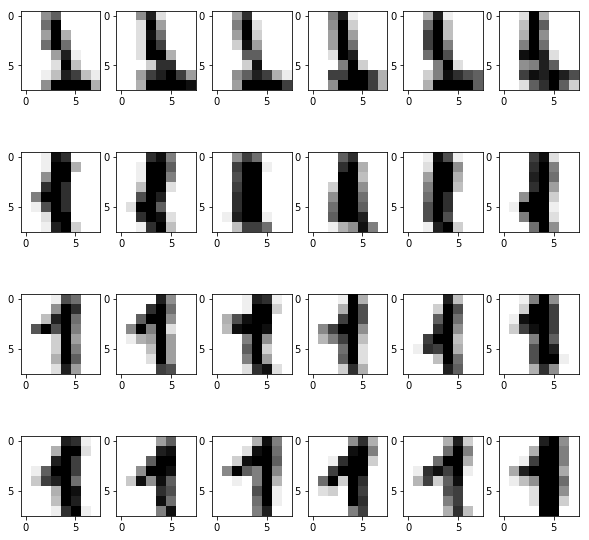

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(10,10))
for i, ex in enumerate([ex1a, ex1b, ex1c, ex1d]):
    for j in range(6):
        axes[i,j].imshow(ex[j].reshape([8,8]), plt.cm.gray_r)
plt.show()

# Clustering

The main aspect to K-Means is choosing the value of K. There are methods to tune K, which use metrics to measure how well defined and separated the clusters are, but visualizing the clusters is very helpful. 

Looking at the embedded data, let's start with a value of K=12. We can then see what the clusters look like by showing the points in the 2D representation, with their cluster labels. 

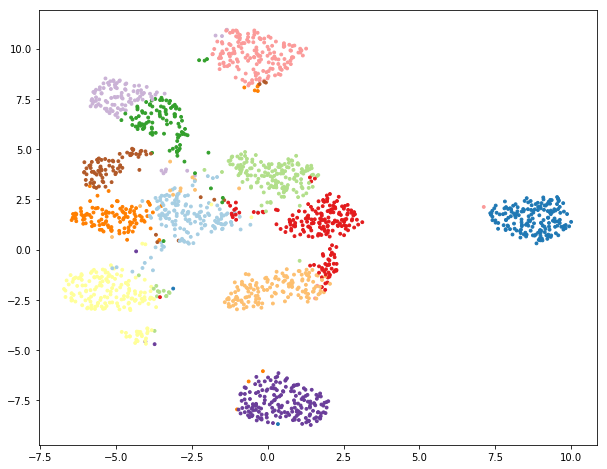

In [12]:
cluster = KMeans(n_clusters = 12, random_state=122)
cluster.fit(X)
c_labels = cluster.labels_

plt.scatter(X_reduced[:, 0], X_reduced[:,1], s=8, c=c_labels, cmap='Paired')

The clustering was done on distances in 64 dimensions, the visualization and embedding is on the 2d projection. 
Neither the clustering nor the embedding is perfect in terms of separating the digit classes (but we wouldn't expect it to be!)

We would expect there to be 10 groups from knowing the real labels, but we can see that there are sub-groups within these.

As the number of clusters is varied, we see how the cluster assignments can change. By eye, each still looks like a *good* grouping of points.

We will try to assess the quality of the clustering using the silhouette score, which reflects the ratio of between-cluster, to within-cluster distances.

In [13]:
for k in [2,8,9,10,11,12,13,14,15,20,25,50]:
    cluster = KMeans(n_clusters=k, random_state=122)
    cluster.fit(X)
    c_labels = cluster.labels_
    score = silhouette_score(X, c_labels)
    print('K={:d} \t score={:.4f}'.format(k, score))

K=2 	 score=0.1195
K=8 	 score=0.1780
K=9 	 score=0.1882
K=10 	 score=0.1811
K=11 	 score=0.1811
K=12 	 score=0.1812
K=13 	 score=0.1832
K=14 	 score=0.1862
K=15 	 score=0.1826
K=20 	 score=0.1683
K=25 	 score=0.1497
K=50 	 score=0.1389


We'll choose a value of K=13.

In [14]:
cluster = KMeans(n_clusters = 13, random_state=122)
cluster.fit(X)
c_labels = cluster.labels_

# Visualizing Groups with Bokeh

We'll now look at how the clusters compare with the true labels. To do this we will use Bokeh.

In [15]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.transform import linear_cmap
from bokeh.models import ColumnDataSource, HoverTool, ColorBar
import bokeh.palettes as bp

output_notebook()

spectral = bp.d3['Category20'][max(c_labels)+1]
source = ColumnDataSource(data={'x1': X_reduced[:,0], 
                                'x2': X_reduced[:,1],
                                'cluster': c_labels,
                                'digit': labels})
p = figure(tools='pan,box_zoom,save,reset', plot_width=800, plot_height=800, title='Digit Clusters')
hover = HoverTool()
hover.tooltips = [('Cluster label', '@cluster'), ('Digit', '@digit')]
p.tools.append(hover)
cmapper = linear_cmap('cluster', spectral, 0, max(c_labels))
p.scatter('x1', 'x2', source=source, size=8, marker='circle', line_color='lightgrey',
          fill_color=cmapper, fill_alpha=0.6)
color_bar = ColorBar(color_mapper=cmapper['transform'], location=(0,0))
p.add_layout(color_bar, 'right')
p.grid.grid_line_color = None
p.xaxis.visible = False
p.yaxis.visible = False
p.outline_line_width = 3
p.outline_line_color = 'gainsboro'
show(p)

Loading BokehJS ...

## Extra

If we classify the points using the cluster labels, how accurate would it be?

In [12]:
from scipy.stats import mode

predicted_labels = np.zeros_like(labels)
for c in np.unique(c_labels):
    predicted_labels[c_labels == c] = mode(labels[c_labels == c])[0][0]

accuracy = (predicted_labels == labels).sum()/len(labels)
print(accuracy)

0.8770172509738453
